In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [3]:
import torch
from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, random_split

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Data loading

In [5]:
transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize((0.5,), (0.5,))
])

# the dataset is 600 by 600
dataset = datasets.ImageFolder('data', transform=transform)

In [6]:
TRAIN_PORTION = 0.8

train_size = int(TRAIN_PORTION * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [6]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Homebrew CNN

In [24]:
class FaceClasifier(nn.Module):
	def __init__(self):
		super(FaceClasifier, self).__init__()
		self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1)
		self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
		self.pool = nn.MaxPool2d(3, 3)
		self.fc1 = nn.Linear(32 * 32 * 32, 128)
		self.fc2 = nn.Linear(128, 2)
		self.dropout = nn.Dropout(0.25)
		self.relu = nn.LeakyReLU()

	def forward(self, x):
		# x 3x600x600
		x = self.pool(self.relu(self.conv1(x)))
		# x 16x199x199
		x = self.pool(self.relu(self.conv2(x)))
		# x 32x32x32
		x = x.view(-1, 32 * 32 * 32)
		x = self.relu(self.fc1(x))
		x = self.fc2(x)
		return x

In [25]:
model = FaceClasifier().to(device)

In [26]:
for name, param in model.named_parameters():
	# print parameter name and size
	print(f"{name: <13} {param.numel(): >15,}")
print('-----------------------------')
print(f'Total parameters: {sum(p.numel() for p in model.parameters()): >11,}')

conv1.weight              432
conv1.bias                 16
conv2.weight           12,800
conv2.bias                 32
fc1.weight          4,194,304
fc1.bias                  128
fc2.weight                256
fc2.bias                    2
-----------------------------
Total parameters:   4,207,970


In [27]:
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [31]:
num_epochs = 3
from collections import defaultdict

train_losses = defaultdict(list)

for epoch in range(num_epochs):
	num_batches = len(train_loader)
	for i, (inputs, label) in tqdm(enumerate(train_loader, 1), total=num_batches, desc=f"Epoch {epoch + 1}/{num_epochs}"):
		inputs = inputs.to(device)
		label = label.to(device)
		optimizer.zero_grad()
		outputs = model(inputs)
		loss = criteria(outputs, label)
		loss.backward()
		optimizer.step()
		train_losses["batch"].append(i + num_batches * epoch)
		train_losses["loss"].append(loss.item())

print('Finished Training')

Epoch 1/3:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 2/3:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 3/3:   0%|          | 0/26 [00:00<?, ?it/s]

Finished Training


In [32]:
# test accuracy
correct = 0
total = 0
for inputs, label in test_loader:
	inputs = inputs.to(device)
	label = label.to(device)
	outputs = model(inputs)
	_, predicted = torch.max(outputs.data, 1)
	total += label.size(0)
	correct += (predicted == label).sum().item()

print(f'Accuracy of the network on the {total} test images: {100 * correct / total:.2f}%')

Accuracy of the network on the 409 test images: 60.15%


In [34]:
# train accuracy
correct = 0
total = 0
for inputs, label in train_loader:
	inputs = inputs.to(device)
	label = label.to(device)
	outputs = model(inputs)
	_, predicted = torch.max(outputs.data, 1)
	total += label.size(0)
	correct += (predicted == label).sum().item()

print(f'Accuracy of the network on the {total} train images: {100 * correct / total:.2f}%')

Accuracy of the network on the 1632 train images: 67.71%


# Trying different non sequential models

In [7]:
class NonSequentialFaceClassifieir(nn.Module):
	def __init__(self):
		super(NonSequentialFaceClassifieir, self).__init__()
		self.start_conv = nn.Conv2d(3, 16, kernel_size=3, stride=1)

		self.left_conv1 = nn.Conv2d(16, 24, kernel_size=5, stride=1)
		self.left_conv2 = nn.Conv2d(24, 32, kernel_size=5, stride=1)
		self.left_conv3 = nn.Conv2d(32, 4, kernel_size=7, stride=1)

		self.right_conv1 = nn.Conv2d(16, 24, kernel_size=3, stride=1)
		self.right_conv2 = nn.Conv2d(24, 32, kernel_size=3, stride=1)
		self.right_conv3 = nn.Conv2d(32, 4, kernel_size=7, stride=1)

		self.left_fc = nn.Linear(4*20*20, 32)
		self.right_fc = nn.Linear(4*21*21, 32)
		self.join_fc = nn.Linear(64, 2)
		
		self.pool2 = nn.MaxPool2d(2, 2)
		self.pool3 = nn.MaxPool2d(3, 3)
		#self.dropout = nn.Dropout(0.25)
		self.relu = nn.LeakyReLU()

	def forward(self, x):
		# x 3x600x600
		x = self.pool2(self.relu(self.start_conv(x)))
		# x 16x299x299

		left = self.pool2(self.relu(self.left_conv1(x)))
		# left 24x147x147
		left = self.pool3(self.relu(self.left_conv2(left)))
		# left 32x47x47
		left = self.pool2(self.relu(self.left_conv3(left)))
		# left 4x21x21
		left = left.view(-1, 4*20*20)
		left = self.relu(self.left_fc(left))

		right = self.pool2(self.relu(self.right_conv1(x)))
		# right 24x148x148
		right = self.pool3(self.relu(self.right_conv2(right)))
		# right 32x48x48
		right = self.pool2(self.relu(self.right_conv3(right)))
		# right 4x21x21
		right = right.view(-1, 4*21*21)
		right = self.relu(self.right_fc(right))

		x = torch.cat((left, right), dim=1)
		x = self.join_fc(x)
		return x

In [8]:
model = NonSequentialFaceClassifieir().to(device)

In [9]:
for name, param in model.named_parameters():
	# print parameter name and size
	print(f"{name: <18} {param.numel(): >15,}")
print('-----------------------------------')
print(f'Total parameters: {sum(p.numel() for p in model.parameters()): >16,}')

start_conv.weight              432
start_conv.bias                 16
left_conv1.weight            9,600
left_conv1.bias                 24
left_conv2.weight           19,200
left_conv2.bias                 32
left_conv3.weight            6,272
left_conv3.bias                  4
right_conv1.weight           3,456
right_conv1.bias                24
right_conv2.weight           6,912
right_conv2.bias                32
right_conv3.weight           6,272
right_conv3.bias                 4
left_fc.weight              51,200
left_fc.bias                    32
right_fc.weight             56,448
right_fc.bias                   32
join_fc.weight                 128
join_fc.bias                     2
-----------------------------------
Total parameters:          160,122


In [10]:
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
num_epochs = 3
from collections import defaultdict
history = defaultdict(list)

for epoch in range(num_epochs):
	for i, (train, label) in tqdm(enumerate(train_loader, 1), total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}"):
		train = train.to(device)
		label = label.to(device)
		optimizer.zero_grad()
		outputs = model(train)
		loss = criteria(outputs, label)
		loss.backward()
		optimizer.step()
		history["batch"].append(i + len(train_loader) * epoch)
		history["loss"].append(loss.item())
		print("batch:", i + len(train_loader) * epoch, "loss:", loss.item())
	print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch 1/3:   0%|          | 0/26 [00:00<?, ?it/s]

batch: 1 loss: 0.708857536315918
batch: 2 loss: 0.6983399391174316
batch: 3 loss: 0.6713575720787048
batch: 4 loss: 0.841963529586792
batch: 5 loss: 0.733074963092804
batch: 6 loss: 0.6964792609214783
batch: 7 loss: 0.6984120011329651
batch: 8 loss: 0.7125332355499268
batch: 9 loss: 0.7032606601715088
batch: 10 loss: 0.7037613987922668
batch: 11 loss: 0.7031676769256592
batch: 12 loss: 0.6948886513710022
batch: 13 loss: 0.6926650404930115
batch: 14 loss: 0.6957420706748962
batch: 15 loss: 0.6950023770332336
batch: 16 loss: 0.6971662044525146
batch: 17 loss: 0.6922069191932678
batch: 18 loss: 0.6917958855628967
batch: 19 loss: 0.6907815933227539
batch: 20 loss: 0.6924480199813843
batch: 21 loss: 0.7008078098297119
batch: 22 loss: 0.6918615698814392
batch: 23 loss: 0.691635012626648
batch: 24 loss: 0.6945517659187317
batch: 25 loss: 0.6864508986473083
batch: 26 loss: 0.7000986337661743
Epoch [1/3], Loss: 0.7001


Epoch 2/3:   0%|          | 0/26 [00:00<?, ?it/s]

batch: 27 loss: 0.653517484664917
batch: 28 loss: 0.6976638436317444
batch: 29 loss: 0.7380903363227844
batch: 30 loss: 0.6851528286933899
batch: 31 loss: 0.6865273714065552
batch: 32 loss: 0.6894882321357727
batch: 33 loss: 0.6970022916793823
batch: 34 loss: 0.688902735710144
batch: 35 loss: 0.6942437291145325
batch: 36 loss: 0.6881240606307983
batch: 37 loss: 0.6868188977241516
batch: 38 loss: 0.6982330083847046
batch: 39 loss: 0.6890639066696167
batch: 40 loss: 0.6864609122276306
batch: 41 loss: 0.6847558617591858
batch: 42 loss: 0.6871620416641235
batch: 43 loss: 0.673317551612854
batch: 44 loss: 0.6594820618629456
batch: 45 loss: 0.697297215461731
batch: 46 loss: 0.7147015333175659
batch: 47 loss: 0.6770121455192566
batch: 48 loss: 0.6740806102752686
batch: 49 loss: 0.6753422617912292
batch: 50 loss: 0.6952528953552246
batch: 51 loss: 0.6787893176078796
batch: 52 loss: 0.7029276490211487
Epoch [2/3], Loss: 0.7029


Epoch 3/3:   0%|          | 0/26 [00:00<?, ?it/s]

batch: 53 loss: 0.691433846950531
batch: 54 loss: 0.641864538192749
batch: 55 loss: 0.649276077747345
batch: 56 loss: 0.6657522320747375
batch: 57 loss: 0.747175931930542
batch: 58 loss: 0.6384537816047668
batch: 59 loss: 0.6677986979484558
batch: 60 loss: 0.6637804508209229
batch: 61 loss: 0.6843648552894592
batch: 62 loss: 0.6781657338142395
batch: 63 loss: 0.6499625444412231
batch: 64 loss: 0.6760348677635193
batch: 65 loss: 0.6681972146034241
batch: 66 loss: 0.6503133773803711
batch: 67 loss: 0.6462848782539368
batch: 68 loss: 0.6453086733818054
batch: 69 loss: 0.6650817394256592
batch: 70 loss: 0.7145400643348694
batch: 71 loss: 0.6479955315589905
batch: 72 loss: 0.5719088315963745
batch: 73 loss: 0.7448041439056396
batch: 74 loss: 0.6292271018028259
batch: 75 loss: 0.7319128513336182
batch: 76 loss: 0.7165075540542603
batch: 77 loss: 0.7169836163520813
batch: 78 loss: 0.7022318243980408
Epoch [3/3], Loss: 0.7022


In [12]:
# train accuracy
correct = 0
total = 0
for inputs, label in train_loader:
	inputs = inputs.to(device)
	label = label.to(device)
	outputs = model(inputs)
	_, predicted = torch.max(outputs.data, 1)
	total += label.size(0)
	correct += (predicted == label).sum().item()

print(f'Accuracy of the network on the {total} train images: {100 * correct / total:.2f}%')

Accuracy of the network on the 1632 train images: 49.26%


In [13]:
# test accuracy
correct = 0
total = 0
for inputs, label in test_loader:
	inputs = inputs.to(device)
	label = label.to(device)
	outputs = model(inputs)
	_, predicted = torch.max(outputs.data, 1)
	total += label.size(0)
	correct += (predicted == label).sum().item()

print(f'Accuracy of the network on the {total} test images: {100 * correct / total:.2f}%')

Accuracy of the network on the 409 test images: 49.63%


In [ ]:
import matplotlib.pyplot as plt

plt.plot(history["batch"], history["loss"])

# VGG16 transfer learning

In [1]:
num_preused_features = 24
augment_factor = 20

In [7]:
vgg16 = models.vgg16(weights='DEFAULT')

In [9]:
class AugmentDataset(Dataset):
	def __init__(self, dataset, expansion):
		self.dataset = dataset
		self.expansion = expansion

	def __len__(self):
		return len(self.dataset) * self.expansion

	def __getitem__(self, idx):
		original, label = self.dataset[idx % len(self.dataset)]
		return original, label

In [8]:
vgg16_prefix = vgg16.features[:num_preused_features]
vgg16_prefix.to(device)

class PrecomputeDataset(Dataset):
	def __init__(self, dataset):
		self.dataset = dataset
		self.precomputed = {}

	def __len__(self):
		return len(self.dataset)

	def __getitem__(self, idx):
		if idx not in self.precomputed:
			original, label = self.dataset[idx]
			precomputed = vgg16_prefix(original.to(device)).detach().cpu()
			self.precomputed[idx] = (precomputed, label)
		return self.precomputed[idx]

In [10]:
transform_train = transforms.Compose([
	transforms.Resize((224, 224)),
	transforms.RandomRotation(30), 
	transforms.RandomHorizontalFlip(),
	transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
	transforms.Resize((224, 224)),
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])


train_dataset = datasets.ImageFolder('data', transform=transform_train)
test_dataset = datasets.ImageFolder('data', transform=transform_test)

indices = torch.randperm(len(train_dataset))
train_size = int(TRAIN_PORTION * len(train_dataset))

train_dataset = torch.utils.data.Subset(train_dataset, indices[:train_size])
test_dataset = torch.utils.data.Subset(test_dataset, indices[train_size:])

train_dataset = AugmentDataset(train_dataset, augment_factor)

train_dataset = PrecomputeDataset(train_dataset)
test_dataset = PrecomputeDataset(test_dataset)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [11]:
class PrecomputedClassifier(nn.Module):
	def __init__(self):
		super(PrecomputedClassifier, self).__init__()
		self.seq = nn.Sequential(
			nn.Conv2d(512, 256, kernel_size=3),
			nn.ReLU(),
			nn.Conv2d(256, 128, kernel_size=3),
			nn.ReLU(),
			nn.Flatten(start_dim=-3), # flatten all but batch dimension
			nn.Linear(12800, 4096),
			nn.ReLU(),
			nn.BatchNorm1d(4096),
			nn.Linear(4096, 2048),
			nn.ReLU(),
			nn.BatchNorm1d(2048),
			nn.Dropout(0.5),
			nn.Linear(2048, 1024),
			nn.ReLU(),
			nn.BatchNorm1d(1024),
			nn.Dropout(0.5),
			nn.Linear(1024, 512),
			nn.ReLU(),
			nn.BatchNorm1d(512),
			nn.Linear(512, 2),
		)

	def forward(self, x):
		return self.seq(x)

In [12]:
model = PrecomputedClassifier().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1E-5)

In [13]:
s = sum(p.numel() for p in model.parameters())
for name, p in model.named_parameters():
	print(f"{name: <13}: {p.numel(): >12,}")

print('-' * 27)
print(f"Total: {s: >20,}")

seq.0.weight :    1,179,648
seq.0.bias   :          256
seq.2.weight :      294,912
seq.2.bias   :          128
seq.5.weight :   52,428,800
seq.5.bias   :        4,096
seq.7.weight :        4,096
seq.7.bias   :        4,096
seq.8.weight :    8,388,608
seq.8.bias   :        2,048
seq.10.weight:        2,048
seq.10.bias  :        2,048
seq.12.weight:    2,097,152
seq.12.bias  :        1,024
seq.14.weight:        1,024
seq.14.bias  :        1,024
seq.16.weight:      524,288
seq.16.bias  :          512
seq.18.weight:          512
seq.18.bias  :          512
seq.19.weight:        1,024
seq.19.bias  :            2
---------------------------
Total:           64,937,858


In [14]:
from collections import defaultdict

epochs = 10
history = defaultdict(list)

for epoch in range(epochs):
	for i, (inputs, label) in (pbar := tqdm(enumerate(train_loader, 1), total=len(train_loader), desc=f"Epoch {epoch + 1}/{epochs}")):
		optimizer.zero_grad()

		inputs = inputs.to(device)
		label = label.to(device)

		outputs = model(inputs)
		loss = criterion(outputs, label)

		loss.backward()
		optimizer.step()

		history["loss"].append(loss.item())
		pbar.set_postfix(loss=loss.item())


Epoch 1/10:   0%|          | 0/510 [00:00<?, ?it/s]

/home/aurora/miniconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400440653/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 2/10:   0%|          | 0/510 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/510 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/510 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/510 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/510 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/510 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/510 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/510 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/510 [00:00<?, ?it/s]

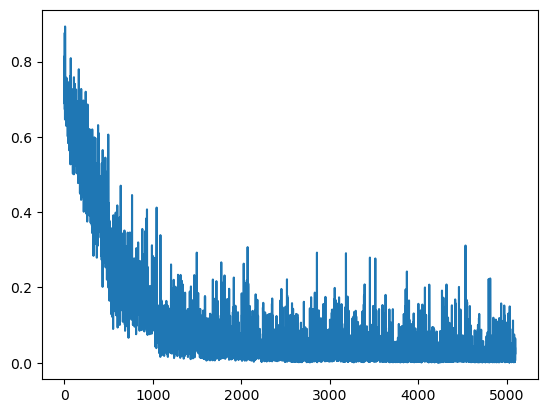

In [15]:
plt.plot(history["loss"])

In [18]:
torch.save(model.state_dict(), 'vgg16_model.pt')

In [ ]:
model = torch.load('vgg16_model.pt')

In [16]:
correct = 0
total = 0

with torch.no_grad():
	for inputs, label in test_loader:
		inputs = inputs.to(device)
		label = label.to(device)
		outputs = model(inputs)
		_, predicted = torch.max(outputs.data, 1)
		total += label.size(0)
		correct += (predicted == label).sum().item()

print(f'Accuracy of the network on the {total} test images: {100 * correct / total:.2f}%')

Accuracy of the network on the 409 test images: 67.24%


In [17]:
correct = 0
total = 0

with torch.no_grad():
	for inputs, label in train_loader:
		inputs = inputs.to(device)
		label = label.to(device)
		outputs = model(inputs)
		_, predicted = torch.max(outputs.data, 1)
		total += label.size(0)
		correct += (predicted == label).sum().item()

print(f'Accuracy of the network on the {total} train images: {100 * correct / total:.2f}%')

Accuracy of the network on the 32640 train images: 99.32%


# Multi model approach

In [8]:
transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize((0.5,), (0.5,))
])

In [9]:
train_names = ['left_eye', 'right_eye', 'mouth', 'nose']
train_datasets = {name: datasets.ImageFolder(f'data_{name}', transform=transform) for name in train_names}

In [10]:
train_loaders = {name: DataLoader(train_datasets[name], batch_size=64, shuffle=True) for name in train_names}

In [11]:
models = {name: FaceClasifier().to(device) for name in train_names}
optimizers = {name: torch.optim.Adam(models[name].parameters(), lr=0.001) for name in train_names}
criteria = nn.CrossEntropyLoss()

In [13]:
epochs = 1
from collections import defaultdict

train_losses = {name: defaultdict(list) for name in train_names}

for feature in train_names:
	model = models[feature]
	optimizer = optimizers[feature]
	loader = train_loaders[feature]
	history = train_losses[feature]
	for epoch in range(epochs):
		for i, (train, label) in tqdm(enumerate(loader, 1), total=len(loader), desc=f"[{feature}] Epoch {epoch + 1}/{epochs}"):
			train = train.to(device)
			label = label.to(device)
			optimizer.zero_grad()
			outputs = model(train)
			loss = criteria(outputs, label)
			loss.backward()
			optimizer.step()
			history["batch"].append(i + len(loader) * epoch)
			history["loss"].append(loss.item())

[left_eye] Epoch 1/1:   0%|          | 0/22 [00:00<?, ?it/s]

[right_eye] Epoch 1/1:   0%|          | 0/22 [00:00<?, ?it/s]

[mouth] Epoch 1/1:   0%|          | 0/22 [00:00<?, ?it/s]

[nose] Epoch 1/1:   0%|          | 0/22 [00:00<?, ?it/s]

In [14]:
torch.save(models, 'models.pt')

In [12]:
models = torch.load('models.pt')
for m in models.values():
	m.to(device)

In [ ]:
import matplotlib.pyplot as plt

# show a 2 by 2 grid
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

for i, feature in enumerate(train_names):
	axs[i // 2, i % 2].plot(train_losses[feature]["batch"], train_losses[feature]["loss"])
	axs[i // 2, i % 2].set_title(feature)
	axs[i // 2, i % 2].set_xlabel("batch")
	axs[i // 2, i % 2].set_ylim(0, 1)

In [13]:
train = datasets.ImageFolder('data_train', transform=transform)
train = DataLoader(train, batch_size=64, shuffle=True)

dat, i = next(iter(train))
dat.shape

torch.Size([64, 3, 600, 600])

In [13]:
class EnsembleModel(nn.Module):
	def __init__(self):
		super(EnsembleModel, self).__init__()
		self.fc1 = nn.Linear(8, 32)
		self.fc2 = nn.Linear(32, 2)
		self.relu = nn.LeakyReLU()

	def forward(self, x):
		x = self.relu(self.fc1(x))
		x = self.fc2(x)
		return x

In [14]:
ensemblemodel = EnsembleModel().to(device)
optimizer = torch.optim.Adam(params=ensemblemodel.parameters(), lr=0.001)
criteria = nn.CrossEntropyLoss()

In [17]:
batches = []
for (inputs, label) in tqdm(train, total=len(train)):
	with torch.no_grad():
		ys = [models[name](inputs) for name in train_names]
		z = torch.cat(ys, dim=1)
		batches.append((z, label))

  0%|          | 0/26 [00:00<?, ?it/s]

In [ ]:
epochs = 50
for epoch in range(epochs):
	for i,(inputs, label) in tqdm(enumerate(batches, 1), total=len(batches), desc=f"Epoch {epoch + 1}/{epochs}"):
		inputs = inputs.to(device)
		label = label.to(device)
		optimizer.zero_grad()
		output = ensemblemodel(inputs)
		loss = criteria(output, label)
		loss.backward()
		optimizer.step()

torch.save(ensemblemodel, 'ensemble_model.pt')
print('Finished Training')

In [22]:
torch.save(ensemblemodel, 'ensemble_model.pt')

In [15]:
ensemblemodel = torch.load('ensemble_model.pt')
ensemblemodel.to(device)

EnsembleModel(
  (fc1): Linear(in_features=8, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

In [16]:
test_dataset = datasets.ImageFolder('data_test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [20]:
test_batches = []
for inputs, label in test_loader:
	inputs = inputs.to(device)
	label = label.to(device)
	with torch.no_grad():
		ys = [models[name](inputs) for name in train_names]
		z = torch.cat(ys, dim=1)
		test_batches.append((z, label))

In [19]:
correct = 0

for inputs, label in test_batches:
	with torch.no_grad():
		output = ensemblemodel(inputs)
		_, predicted = torch.max(output.data, 1)
		correct += (predicted == label).sum().item()

print(f'Accuracy of the network on the {len(test_dataset)} test images: {100 * correct / len(test_dataset):.2f}%')

Accuracy of the network on the 410 test images: 56.83%


## Multi model using VGG 16